# Build HDF5 Container Input for GCN from Methylation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='Times New Roman')
import seaborn, h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Load Sample Methylation Matrix

In [2]:
meth_all_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_sample_matrix_450_tcgaannot.tsv',
                               sep='\t')
# rename first column to 'Symbol'
meth_all_samples.columns = ['Symbol'] + meth_all_samples.columns[1:].tolist()
meth_all_samples.head()

,Symbol,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|support_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_promoter,TCGA-AB-2967-03A-01D-0742-05|laml|mean_beta_value_promoter,TCGA-AB-2967-03A-01D-0742-05|laml|support_promoter,TCGA-DQ-7588-01A-11D-2079-05|hnsc|mean_beta_value_promoter,TCGA-DQ-7588-01A-11D-2079-05|hnsc|support_promoter,TCGA-AB-2873-03A-01D-0742-05|laml|mean_beta_value_promoter,...,TCGA-A6-5656-01A-21D-A27A-05|coad|mean_beta_value_promoter,TCGA-A6-5656-01A-21D-A27A-05|coad|support_promoter,TCGA-D5-6930-01A-11D-1926-05|coad|mean_beta_value_promoter,TCGA-D5-6930-01A-11D-1926-05|coad|support_promoter,TCGA-A6-5656-01B-02D-A27A-05|coad|mean_beta_value_promoter,TCGA-A6-5656-01B-02D-A27A-05|coad|support_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|mean_beta_value_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|support_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|support_promoter
0,A1BG,0.461925,9.0,0.189681,9.0,0.532902,9.0,0.424307,9.0,0.519879,...,0.481461,9.0,0.557021,9.0,0.498841,9.0,0.332862,9.0,0.446320,9.0
1,A1CF,0.881828,3.0,0.250301,3.0,0.799332,3.0,0.462136,3.0,0.754143,...,0.310399,3.0,0.614371,3.0,0.493545,3.0,0.434046,3.0,0.349528,3.0
2,A2M,0.582412,2.0,0.464732,2.0,0.531249,2.0,0.529455,2.0,0.586573,...,0.483539,2.0,0.580142,2.0,0.452237,2.0,0.406105,2.0,0.521644,2.0
3,A2ML1,0.871176,8.0,0.586723,8.0,0.887802,8.0,0.501774,8.0,0.839751,...,0.544186,8.0,0.800718,8.0,0.647372,8.0,0.572836,8.0,0.598413,8.0
4,A4GALT,0.055650,7.0,0.029784,7.0,0.113250,7.0,0.035935,7.0,0.029488,...,0.029026,7.0,0.354046,7.0,0.053301,7.0,0.027099,7.0,0.027909,7.0


In [3]:
barcodes = [n.split('|')[0] for n in meth_all_samples.columns[1:] if "mean_beta_value_promoter" in n]
sample_types = [i.split('-')[3] for i in barcodes]
for st in np.unique(sample_types):
    print ("{}: {}".format(st, sample_types.count(st)))

# when the fourth part of the barcode starts with 0, it has to be tumor sample
tumor_sample_cols = ['Symbol'] + [i for i in meth_all_samples.columns[1:] if i.split('|')[0].split('-')[3].startswith('0')]
meth_all_tumor_samples = meth_all_samples[tumor_sample_cols]

01A: 3810
01B: 86
01C: 7
02A: 17
02B: 1
03A: 140
05A: 1
06A: 9
11A: 473
11B: 21


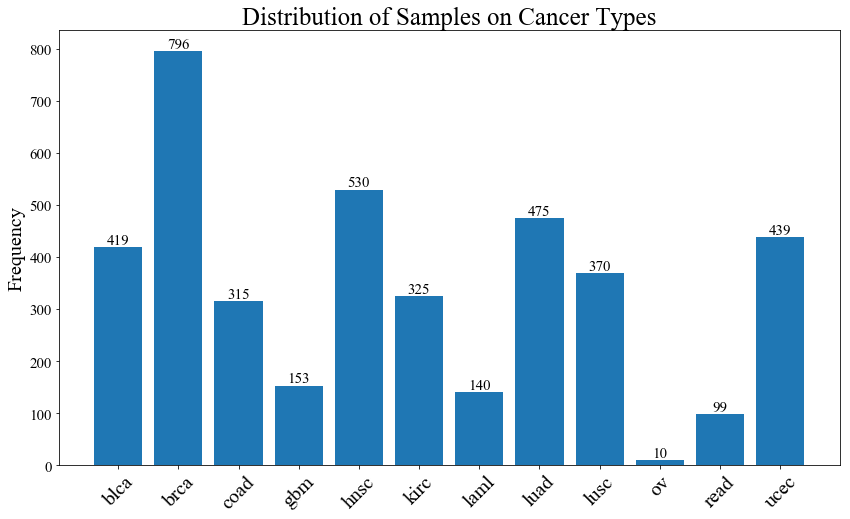

In [4]:
c_types = [n.split('|')[1] for n in meth_all_tumor_samples.columns[1:] if "mean_beta_value_promoter" in n]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
b = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)

# Add counts above the two bar graphs
for rect in b:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', size=15)

fig.savefig('../../data/pancancer/TCGA/methylation/samples_per_cancertype.svg')

In [5]:
barcodes = [n.split('|')[0] for n in meth_all_tumor_samples.columns[1:] if "mean_beta_value_promoter" in n]
sample_types = [i.split('-')[3] for i in barcodes]
for st in np.unique(sample_types):
    print ("{}: {}".format(st, sample_types.count(st)))

01A: 3810
01B: 86
01C: 7
02A: 17
02B: 1
03A: 140
05A: 1
06A: 9


## 2. Mean Samples Across Cancer Types

In [6]:
# first, transpose and add column with cancer type
meth_t = meth_all_tumor_samples.T
meth_t['cancer_type'] = [None] + [i[1] for i in meth_t.index.str.split('|')[1:]]

# remove everything that is not a promoter beta value (remove support and gene body methylation)
meth_prom_only = meth_t[meth_t.index.str.contains('beta_value_promoter')]
meth_gene_only = meth_t[meth_t.index.str.contains('beta_value_gene')]

# compute mean across all cancer types
meth_prom_only_mean = meth_prom_only.fillna(0).groupby('cancer_type').mean().T
meth_prom_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
meth_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

if meth_gene_only.shape[0] > 0:
    meth_gene_only_mean = meth_gene_only.fillna(0).groupby('cancer_type').mean().T
    meth_gene_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
    meth_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [7]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = meth_prom_only_mean.columns
meth_prom_only_mean['kind'] = 'Promoter'
if meth_gene_only.shape[0] > 0:
    meth_gene_only_mean['kind'] = 'Gene Body'
    both = pd.concat((meth_prom_only_mean, meth_gene_only_mean))
else:
    both = meth_prom_only_mean
# convert to long format
long_format = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

In [8]:
# plot violinplot if we have gene body methylation too
if meth_gene_only.shape[0] > 0:
    fig = plt.figure(figsize=(20, 10))
    ax = seaborn.violinplot(x='cancer_type', y='value', hue='kind', data=long_format, dodge=True)
    plt.xlabel('')
    plt.ylabel('Beta Value', fontsize=20)
    plt.title('DNA Methylation Across Cancer Types', fontsize=30)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    _ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
    fig.savefig('../../data/pancancer/TCGA/methylation/beta_values_cancertype.png')

In [9]:
# now, get the same means for the support
sup_prom_only = meth_t[meth_t.index.str.contains('support_promoter')]
sup_gene_only = meth_t[meth_t.index.str.contains('support_gene')]

# compute mean across all cancer types
sup_prom_only_mean = sup_prom_only.fillna(0).groupby('cancer_type').mean().T
sup_prom_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
sup_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

if sup_gene_only.shape[0] > 0:
    sup_gene_only_mean = sup_gene_only.fillna(0).groupby('cancer_type').mean().T
    sup_gene_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
    sup_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [10]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = sup_prom_only_mean.columns
sup_prom_only_mean['kind'] = 'Promoter'
if sup_gene_only.shape[0] > 0:
    sup_gene_only_mean['kind'] = 'Gene Body'
    both = pd.concat((sup_prom_only_mean, sup_gene_only_mean))
else:
    both = sup_prom_only_mean

# convert to long format
long_format_sup = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

In [11]:
# plot violinplot
if sup_gene_only.shape[0] > 0:
    fig = plt.figure(figsize=(20, 10))
    ax = seaborn.boxplot(x='cancer_type', y='value', hue='kind', data=long_format_sup, dodge=True)
    plt.xlabel('')
    plt.ylabel('# of CpG sites in Region', fontsize=20)
    plt.title('CpG Sites Across Cancer Types', fontsize=30)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    _ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
    fig.savefig('support_means.png')

In [12]:
if meth_gene_only.shape[0] > 0:
    meth_prom_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_promoters_cancers.tsv', sep='\t')
    meth_gene_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_genes_cancers.tsv', sep='\t')
else:
    meth_prom_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_promoters_cancers_tcgaannot.tsv', sep='\t')

## 3. Check Methylation for Oncogenes & Tumor Suppressors

In [13]:
meth_prom_only_mean.head()

cancer_type,blca,brca,coad,gbm,hnsc,kirc,laml,luad,lusc,ov,read,ucec,kind
Symbol,,,,,,,,,,,,,
A1BG,0.354461,0.460693,0.442365,0.468030,0.459186,0.387414,0.524167,0.442781,0.407286,0.382172,0.412684,0.396971,Promoter
A1CF,0.515511,0.657840,0.464441,0.724904,0.685648,0.595793,0.844588,0.669958,0.661210,0.484049,0.446620,0.491574,Promoter
A2M,0.528490,0.586327,0.459945,0.402674,0.535087,0.601125,0.582865,0.538315,0.531127,0.433676,0.433849,0.537136,Promoter
A2ML1,0.621384,0.763030,0.620551,0.789710,0.637103,0.826429,0.906139,0.732395,0.650166,0.695592,0.599118,0.707067,Promoter
A4GALT,0.037004,0.052885,0.127432,0.096698,0.046551,0.034807,0.112903,0.078786,0.040902,0.028574,0.054034,0.037932,Promoter


Got 125 cancer genes
Other       18578
TSG            68
Oncogene       52
Name: type, dtype: int64


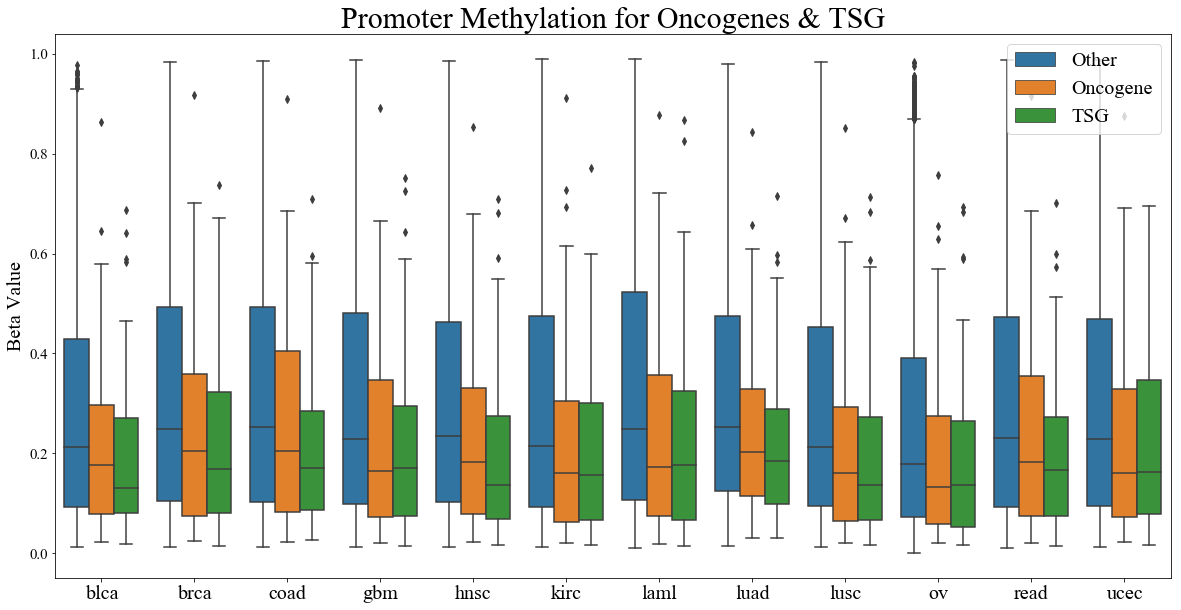

In [14]:
cancer_genes = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
cancer_genes.columns = [i.strip('*') for i in cancer_genes.columns]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} cancer genes".format(cancer_genes.shape[0]))

meth_prom_only_mean_onco = meth_prom_only_mean
meth_prom_only_mean_onco.drop('kind', axis=1, inplace=True, errors='ignore')
meth_prom_only_mean_onco['type'] = 'Other'
meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
print (meth_prom_only_mean_onco.type.value_counts())
# plot
fig = plt.figure(figsize=(20, 10))
ax = seaborn.boxplot(data=pd.melt(meth_prom_only_mean_onco, id_vars=['type']), x='cancer_type', y='value', hue='type', dodge=True)
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.svg')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.png', dpi=300)

In [16]:
s = meth_prom_only_mean.luad.idxmin()
meth_prom_only_mean[meth_prom_only_mean.index == s]

cancer_type,blca,brca,coad,gbm,hnsc,kirc,laml,luad,lusc,ov,read,ucec,type
Symbol,,,,,,,,,,,,,
RBM18,0.012697,0.011821,0.012703,0.011684,0.012994,0.011359,0.011281,0.013722,0.01227,0.011801,0.011763,0.01237,Other


## 4. Integrate Methylation into HDF5 container

In [17]:
# load Container
data_file = '../../data/pancancer/iref_multiomics_norm_ncglabels.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [18]:
y_val.shape, val_mask.shape

((12129, 1), (12129,))

In [19]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# add gene body and promoter information
if meth_gene_only.shape[0] > 0:
    meth_mean_all = pd.concat((meth_prom_only_mean, meth_gene_only_mean), axis=1)
else:
    meth_mean_all = meth_prom_only_mean
features_all = nodes_df.join(meth_mean_all, on='name')

num_of_zero_nodes = features_all.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
features_all.fillna(0, inplace=True)
features_all.drop(['name', 'kind', 'type'], axis=1, inplace=True, errors='ignore')

554 out of 12129 nodes don't have any features assigned
--> left with valid scores for 11575 genes


In [20]:
# get also feature dfs for promoters and genes separately
features_prom = nodes_df.join(meth_prom_only_mean, on='name')
if meth_gene_only.shape[0] > 0:
    features_gene = nodes_df.join(meth_gene_only_mean, on='name')
    features_gene.fillna(0, inplace=True)
    features_gene.drop(['name', 'kind'], axis=1, inplace=True, errors='ignore')

# put 0 for missing data and remove name columns
features_prom.fillna(0, inplace=True)
features_prom.drop(['name', 'type'], axis=1, inplace=True, errors='ignore')


In [21]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [22]:
features = features_all.as_matrix()
fnames = features_all.columns
if meth_gene_only.shape[0] > 0:
    write_hdf5_container('../../data/pancancer/iref_methylation_450k1000bpprom_all.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)
else:
    write_hdf5_container('../../data/pancancer/iref_methylation_450k1000bpprom.h5',
                     network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)

Container written to ../../data/pancancer/iref_methylation_450k1000bpprom.h5


In [23]:
if meth_gene_only.shape[0] > 0:
    features = features_prom.as_matrix()
    fnames = features_prom.columns
    write_hdf5_container('../../data/pancancer/iref_methylation_450k_1000bpprom.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)

In [24]:
if meth_gene_only.shape[0] > 0:
    features = features_gene.as_matrix()
    fnames = features_gene.columns
    write_hdf5_container('../../data/pancancer/iref_methylation_450k_genebody.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, list(c_types))